In [1]:
# Run eight schools
# again, this only works on startup!
import os
from functools import partial

import equinox as eqx
import jax.random as jr
import jaxtyping
import matplotlib.pyplot as plt
import optax
import pandas as pd
import seaborn as sns
from numpyro import handlers
from numpyro.infer import Predictive
import jax
with jaxtyping.install_import_hook(["cnpe", "cnpe_validation"], "beartype.beartype"):
    from cnpe.losses import AmortizedMaximumLikelihood, ContrastiveLoss
    from cnpe.numpyro_utils import get_sample_site_names, prior_log_density
    from cnpe.train import train

    from cnpe_validation.tasks.eight_schools import EightSchoolsTask
    from cnpe_validation.tasks.tasks import AbstractTaskWithReference
    from cnpe_validation.utils import change_initialization, get_abspath_project_root

os.chdir(get_abspath_project_root())

In [2]:
seed = 1
maximum_likelihood_steps = 4000
contrastive_steps = 2000
num_contrastive = 20

key, subkey = jr.split(jr.PRNGKey(seed))
task = EightSchoolsTask(subkey)

key, subkey = jr.split(key)
obs, true_latents = task.get_observed_and_latents_and_check(subkey)

posteriors = {}
metadata = {}

key, subkey = jr.split(key)
guide = change_initialization(
    task.guide,
    subkey,
    jax.nn.initializers.normal(),
    type_filter=eqx.nn.MLP,
    )

# Pretrain using amortized maximum likelihood
loss = AmortizedMaximumLikelihood(task.model)

optimizer = optax.apply_if_finite(
    optax.chain(
        optax.clip_by_global_norm(0.5),
        optax.adam(optax.linear_schedule(5e-4, 1e-4, maximum_likelihood_steps)),
    ),
    max_consecutive_errors=10,
)
method_name = "maximum likelihood"
key, subkey = jr.split(key)
posteriors[method_name], metadata[method_name] = train(
    subkey,
    guide=guide,
    loss_fn=loss,
    steps=maximum_likelihood_steps,
    optimizer=optimizer,
)

# Fine tune with contrastive loss
for stop_grad in [False, True]:
    method_name = f"contrastive (stop grad={stop_grad})"

    loss = ContrastiveLoss(
        model=task.model,
        obs=obs,
        n_contrastive=num_contrastive,
        stop_grad_for_contrastive_sampling=stop_grad,
    )


    optimizer = optax.apply_if_finite(
        optax.chain(
            optax.clip_by_global_norm(0.5),
            optax.adam(1e-4),
        ),
        max_consecutive_errors=100,
    )
    key, subkey = jr.split(key)

    posteriors[method_name], metadata[method_name] = train(
        subkey,
        guide=posteriors["maximum likelihood"],
        loss_fn=loss,
        steps=contrastive_steps,
        optimizer=optimizer,
    )


 46%|████▌     | 917/2000 [01:26<01:42, 10.54it/s, loss=5.2 (Convergence criteria reached.)]


In [3]:

def compute_true_latent_prob(true_latents, posteriors, model, obs):  # For a single latent
    log_probs = {
        k: posterior.log_prob_original_space(
            latents=true_latents,
            model=model,
            obs=obs,
        )
        for k, posterior in posteriors.items()
    }
    log_probs["prior"] = prior_log_density(
        partial(model.call_without_reparam, obs=obs),
        data=true_latents,
        observed_nodes=model.observed_names,
    )
    return log_probs

compute_true_latent_prob = partial(
    compute_true_latent_prob,
    posteriors=posteriors,
    model=task.model,
    obs=obs,
    )

if isinstance(task, AbstractTaskWithReference):  # Batch of "true" samples
    compute_true_latent_prob = eqx.filter_vmap(compute_true_latent_prob)

log_prob_true = compute_true_latent_prob(true_latents)


In [4]:
# {k: p.mean() for k, p in log_prob_true.items()}

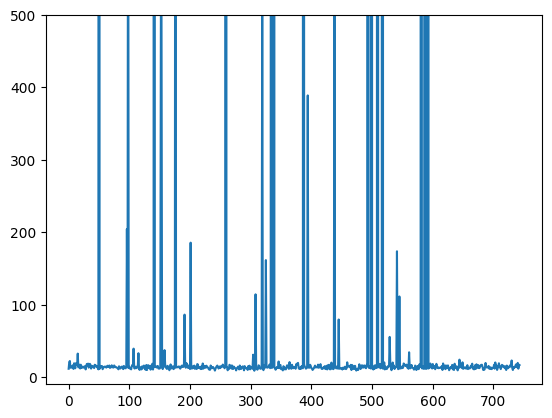

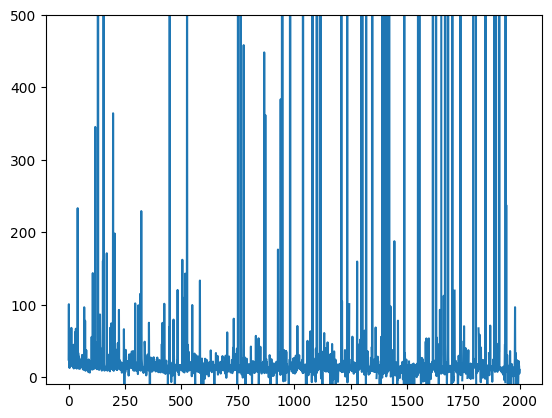

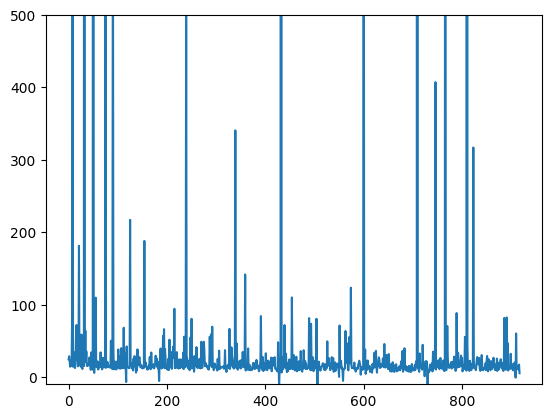

In [5]:
for k, v in metadata.items():
    losses = v["losses"]
    plt.plot(v["losses"], label=k)
    plt.ylim(-10, 500)
    plt.show()

([0, 1, 2, 3],
 [Text(0, 0, 'contrastive (stop grad=False)'),
  Text(1, 0, 'contrastive (stop grad=True)'),
  Text(2, 0, 'maximum likelihood'),
  Text(3, 0, 'prior')])

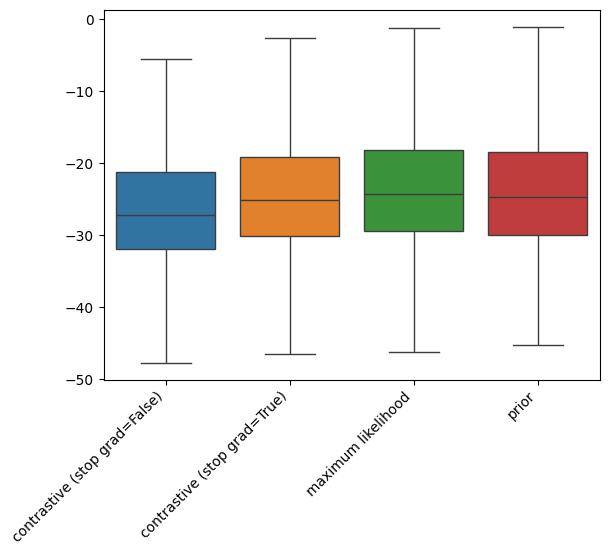

In [6]:
sns.boxplot(pd.DataFrame(log_prob_true), showfliers="")
plt.xticks(rotation=45, ha='right')


In [7]:
key, subkey = jr.split(key)

posterior_samples = {}

for k, posterior in posteriors.items():
    posterior_samples[k] = Predictive(
        posterior,
        num_samples=5000,
        )(key, obs=obs)

# We have to trace the model to avoid the reparamterization

def to_original_space(posterior_samples, model, *args, **kwargs):
    # TODO move into guide class
    posterior_samples = {k: v for k, v in posterior_samples.items()} # Avoid mutating
    trace = handlers.trace(
        handlers.condition(model, posterior_samples),
        ).get_trace(*args, **kwargs)
    
    for name in model.reparam_names:
        posterior_samples.pop(f"{name}_base")
        posterior_samples[name] = trace[name]["value"]

    return posterior_samples


posterior_samples = {k: eqx.filter_vmap(
    partial(to_original_space, model=task.model, obs=obs))(samps)
    for k, samps in posterior_samples.items()
}


In [8]:
key, subkey = jr.split(key)
prior_samples = Predictive(task.model.call_without_reparam, num_samples=5000)(key)
[prior_samples.pop(name) for name in task.model.observed_names]
latent_names = get_sample_site_names(task.model.call_without_reparam, obs=obs).latent

In [9]:
import matplotlib.pyplot as plt

samples = {
    "true_posterior": true_latents,
} | posterior_samples | {"prior": prior_samples}


# for latent in latent_names:
#     if samples["prior"][latent].ndim == 1:
#         for k, samps in samples.items():
#             sns.kdeplot(samps[latent], alpha=0.7, label=k)
#             # plt.hist(samps[latent], alpha=0.7, label=k, density=True, bins=25)
#         plt.title(latent)
#         plt.legend()
#         plt.xlim(true_latents[latent].min(), true_latents[latent].max())
#         plt.show()

# for latent in latent_names:
#     if samples["prior"][latent].ndim == 2:
#         fig, axes = plt.subplots(nrows=samples["prior"][latent].shape[-1])
#         for i, ax in enumerate(axes):
#             for k, samps in samples.items():
#                 sns.kdeplot(samps[latent][:, i], ax=ax, alpha=0.7, label=k)
#                 # ax.hist(samps[latent][:, i], alpha=0.7, label=k, density=True, bins=25)
#                 ax.set_title(f"{latent}_{i}")
#                 ax.set_xlim(true_latents[latent][:, i].min(), true_latents[latent][:, i].max())
#                 if i==0:
#                     fig.legend()
            
#         fig.show()
#         fig.set_size_inches(10, 20)
#         fig.tight_layout()


<Axes: xlabel='parameter_value', ylabel='parameter'>

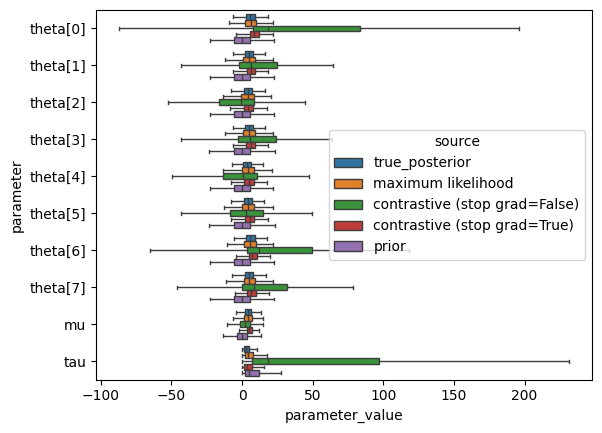

In [10]:
dfs = []
for k, samps in samples.items():

    columns = {}
    for name, arr in samps.items():
        if arr.ndim == 1:
            columns[name] = arr
        
        if arr.ndim == 2:
            for i in range(arr.shape[-1]):
                columns[f"{name}[{i}]"] = arr[:, i]
    df = pd.DataFrame(columns)
    df["source"] = k
    dfs.append(df)

df = pd.concat(dfs)
df = df.melt(id_vars="source", var_name="parameter", value_name="parameter_value")
sns.boxplot(data=df, x="parameter_value", y="parameter", hue="source", showfliers="")
# A good way to plot would likely be to share an axis for thetas, but not for mu and tau